In [35]:
# 0) Setup & Reproducibility (before Task 1)
# ============================================================

# Below modules used in this notebook
import random
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms
import os
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Subset
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import torch.optim as optim
import sys
import time
from tqdm import tqdm

start_time = time.time() # For - Total runtime - SO RUN ALL CELLS AT A TIME

def set_seed(seed=42):
    """set all random seeds for reproducibility here."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f"Fixed random seed value: {seed}")
    print(f"Determinism set - (cudnn.deterministic=True, benchmark=False)")

def get_device():
    """select device (GPU if available, else CPU)."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Also available: {device}")
    if device.type == "cuda":
        print(f"GPU Name: {torch.cuda.get_device_name(0)}")
       # Using CPU in below cells, since device = CPU asked  in assignment for total runtime count
    return device

def print_env_summary():
    """Environment versions."""
    print("\nEnvironment Summary")
    print(f"Python version : {os.sys.version.split()[0]}")
    print(f"Torch version  : {torch.__version__}")
    print(f"Torchvision ver: {torchvision.__version__}")



# Run setup
SEED = 42
set_seed(SEED)
device = get_device()
device = torch.device("cpu") # Using CPU 
print('But using CPU -->', device)
print_env_summary()


Fixed random seed value: 42
Determinism set - (cudnn.deterministic=True, benchmark=False)
Also available: cuda
GPU Name: NVIDIA RTX A2000 12GB
But using CPU --> cpu

Environment Summary
Python version : 3.9.6
Torch version  : 2.5.1+cu121
Torchvision ver: 0.20.1+cu121


In [36]:
# 1) Model Architecture
# 1.1 Base Model Selection
# ============================================================

def get_base_model(model_name="resnet18", pretrained=True):
    """Load ResNet base model with optional pretrained weights."""

    if model_name == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    elif model_name == "resnet34":
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT if pretrained else None)
    elif model_name == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
    else:
        raise ValueError("Invalid model name. Choose from ['resnet18', 'resnet34', 'resnet50'].")

    # Modify the final classification layer
    # in_features = model.fc.in_features
    # model.fc = nn.Linear(in_features, num_classes)

    # Model summary
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Using {model_name}, pretrained={pretrained}")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    #print("Num of classes:", num_classes)

    return model


# Run setup
model = get_base_model(model_name="resnet34", pretrained=True)


Using resnet34, pretrained=True
Total parameters: 21,797,672
Trainable parameters: 21,797,672


In [37]:
# 1.2 Activation Function Replacement
# ============================================================

def replace_relu_after_n(model, n_keep=6, alt_activation=nn.SiLU()):
    """Replace ReLU activations after the n_keep-th occurrence with an alternative activation."""
    relu_indices = []
    count = 0

    # Depth-first traversal 
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            relu_indices.append(name)
            count += 1

    print(f"Total nn.ReLU count before replacement: {count}")

    # Determine which indices to replace
    replace_from = n_keep  # keep first 6, replace from index 6
    to_replace = relu_indices[replace_from:]
    print(f"Replacing ReLU at indices: {list(range(replace_from, count))}")


    # perform replacement for nn.ReLU with nn.SiLU()/nn.GELU()/nn.LeakyReLU(0.01)
    counter = [0]
    _replace_relu_recursive(model, n_keep, alt_activation, counter)


    # Sanity check
    new_relu_count = sum(isinstance(m, nn.ReLU) for m in model.modules())
    alt_count = sum(isinstance(m, alt_activation.__class__) for m in model.modules())

    print(f"ReLU remaining: {new_relu_count}")
    print(f"{alt_activation.__class__.__name__} inserted: {alt_count}")


    # Assertion check
    assert new_relu_count + alt_count == count, \
        "Error: total activations mismatch after replacement"
    assert alt_count == max(0, count - n_keep), \
        "Error: incorrect number of activations replaced"
    return model


def _replace_relu_recursive(module, n_keep, alt_activation, counter):
    """Recursive helper to replace ReLUs"""
    for name, child in module.named_children():
        if isinstance(child, nn.ReLU):
            if counter[0] >= n_keep:
                setattr(module, name, alt_activation.__class__())
            counter[0] += 1
        else:
            _replace_relu_recursive(child, n_keep, alt_activation, counter)


# Run setup
model = replace_relu_after_n(model, n_keep=6, alt_activation=nn.SiLU())

Total nn.ReLU count before replacement: 17
Replacing ReLU at indices: [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
ReLU remaining: 6
SiLU inserted: 11


In [38]:
# 1.3 Classification Head Modification
# ============================================================

def modify_classification_head(model, num_classes=3):
    """Replace the final FC layer (classification head) to match num_classes."""
    # Ensure model has a fully connected layer
    if not hasattr(model, "fc"):
        raise AttributeError("Model has no attribute 'fc'. Ensure it's a ResNet-like architecture.")

    # Get old FC layer
    old_fc = model.fc
    in_features = old_fc.in_features
    out_features = old_fc.out_features

    print(f"Old head shape: in_features={in_features} → out_features={out_features}")

    # Replace FC with new output layer
    model.fc = nn.Linear(in_features, num_classes)

    # New head shape
    new_fc = model.fc
    print(f"New head shape: in_features={new_fc.in_features} → out_features={new_fc.out_features}")
    print(f"Number of target classes: {num_classes}")

    

    return model


# Run setup
model = modify_classification_head(model, num_classes=3)

Old head shape: in_features=512 → out_features=1000
New head shape: in_features=512 → out_features=3
Number of target classes: 3


In [39]:
# 2.1 Dataset Preparation
# ============================================================

# CONFIGURATION
SELECTED_CLASSES = ["cat", "dog", "airplane"]  # pick 2–3 classes
USE_CIFAR_TRAIN_AS_TRAIN_AND_TEST_AS_VAL = True  # else 80/20 split


# 1.----------------Transforms----------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1, 1]
])



# 2. ----------------Load CIFAR-10 dataset (train/test)----------------
data_root = "./data"

# Check if CIFAR-10 is already downloaded or not
if not os.path.exists(os.path.join(data_root, "cifar-10-batches-py")):
    download = True
else:
    download = False

train_dataset_full = datasets.CIFAR10(root=data_root, train=True, download=download, transform=transform)
test_dataset_full  = datasets.CIFAR10(root=data_root, train=False, download=download, transform=transform)



# 3. ----------------Identify class names and selected ones----------------
all_classes = train_dataset_full.classes
print(f"All CIFAR-10 classes: {all_classes}")
print(f"Selected classes: {SELECTED_CLASSES}")


# Create mapping from class name to original label ID
orig_class_to_id = {cls_name: idx for idx, cls_name in enumerate(all_classes)}
selected_class_ids = [orig_class_to_id[c] for c in SELECTED_CLASSES]



# 4. ----------------Filter datasets to selected classes only ["cat", "dog", "airplane"]----------------
def filter_dataset(dataset, selected_ids):
    idxs = [i for i, (_, label) in enumerate(dataset) if label in selected_ids]
    subset = Subset(dataset, idxs)
    return subset

train_subset = filter_dataset(train_dataset_full, selected_class_ids)
test_subset = filter_dataset(test_dataset_full, selected_class_ids)



# 5. ----------------Relabel to contiguous IDs (0, 1, 2, ...)----------------
class_id_map = {orig_id: new_id for new_id, orig_id in enumerate(selected_class_ids)}
class_name_map = {SELECTED_CLASSES[i]: i for i in range(len(SELECTED_CLASSES))}


def relabel_dataset(subset, id_map):
    subset.dataset.targets = np.array(subset.dataset.targets)
    indices = subset.indices
    for i in indices:
        orig_label = subset.dataset.targets[i]
        subset.dataset.targets[i] = id_map[orig_label]
    return subset

train_subset = relabel_dataset(train_subset, class_id_map)
test_subset = relabel_dataset(test_subset, class_id_map)



# 6. ----------------Optionally split train subset into train/val----------------
if USE_CIFAR_TRAIN_AS_TRAIN_AND_TEST_AS_VAL:
    train_dataset, val_dataset = train_subset, test_subset
else:
    train_size = int(0.8 * len(train_subset))
    val_size = len(train_subset) - train_size
    train_dataset, val_dataset = random_split(train_subset, [train_size, val_size])



# 7. ----------------Count samples per class----------------
def count_classes(subset):
    labels = [subset.dataset.targets[i] for i in subset.indices]
    counts = dict(Counter(labels))
    return counts

train_counts = count_classes(train_dataset)
val_counts = count_classes(val_dataset)



# 8. ----------------Print expected outputs----------------
print("\nMapping Tables:")
print(f"Original → New Label IDs: {class_id_map}")
print(f"Class Names → New IDs: {class_name_map}")

print("\nClass Counts:")
print("Set\tClass\tCount")
for cls_name, new_id in class_name_map.items():
    print(f"Train\t{cls_name} ({new_id})\t{train_counts.get(new_id, 0)}")
    print(f"Val\t{cls_name} ({new_id})\t{val_counts.get(new_id, 0)}")


All CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Selected classes: ['cat', 'dog', 'airplane']

Mapping Tables:
Original → New Label IDs: {3: 0, 5: 1, 0: 2}
Class Names → New IDs: {'cat': 0, 'dog': 1, 'airplane': 2}

Class Counts:
Set	Class	Count
Train	cat (0)	5000
Val	cat (0)	1000
Train	dog (1)	5000
Val	dog (1)	1000
Train	airplane (2)	5000
Val	airplane (2)	1000


In [40]:
# 2.2 Data Augmentation
# ============================================================


# 1. ----------------Define transforms----------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



# 2. ----------------Reapply transforms to datasets----------------
# Make sure you apply transforms directly to the subset’s underlying dataset
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform



# 3. ----------------Create DataLoaders----------------
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)



# 4. ----------------Print transform summary----------------
print("\nTransform Summary:")
print("Train Transform:")
for t in train_transform.transforms:
    print(f"  - {t}")
print("\nValidation Transform:")
for t in val_transform.transforms:
    print(f"  - {t}")



# 5. ----------------Sample batch shape check----------------
train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))

print(f"\nSample batch shapes:")
print(f"Train batch: {train_images.shape}, Labels: {train_labels.shape}")
print(f"Val batch:   {val_images.shape}, Labels: {val_labels.shape}")



# 6. ----------------Optional: visualize a grid of augmented images----------------
def show_augmented_images(images, labels, class_name_map, n=16):
    images = images[:n]
    labels = labels[:n]
    # Denormalize to display properly
    images = images * 0.5 + 0.5  # revert normalization to [0, 1]
    grid = torchvision.utils.make_grid(images, nrow=8)
    plt.figure(figsize=(10, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    class_labels = [list(class_name_map.keys())[i.item()] for i in labels]
    plt.title(f"Sample Augmented Train Images\nLabels: {class_labels}")
    plt.show()


# show_augmented_images(train_images, train_labels, class_name_map)



Transform Summary:
Train Transform:
  - RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
  - RandomHorizontalFlip(p=0.5)
  - ToTensor()
  - Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

Validation Transform:
  - Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
  - CenterCrop(size=(32, 32))
  - ToTensor()
  - Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

Sample batch shapes:
Train batch: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])
Val batch:   torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])


In [41]:
# 3.1 Training Loop
# ============================================================


# Assuming you already have:
# model, train_loader, val_loader, num_classes defined from previous sections

# ----------------Hyperparameters----------------
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # The notebook must run top-to-bottom without manual edits on CPU
epochs = 10
learning_rate = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model = model.to(device)


# ----------------Helper Function for Accuracy----------------
def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels).item()
    total = labels.size(0)
    return correct / total


# ----------------Training Loop----------------
best_val_acc = 0.0
best_epoch = 0

for epoch in range(1, epochs + 1):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_acc += compute_accuracy(outputs, labels)
    
    train_loss = running_loss / len(train_loader)
    train_acc = running_acc / len(train_loader)
    

    # ----------------Validation Loop----------------
    model.eval()
    val_loss, val_acc = 0.0, 0.0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            val_acc += compute_accuracy(outputs, labels)
    
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    
    # Scheduler step
    scheduler.step()
    
    # Epoch Summary
    print(f"Epoch {epoch}/{epochs} | "
          f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | "
          f"Val Loss: {val_loss:.3f} | Val Acc: {val_acc*100:.2f}%")
    
    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), "best_model.pth")

print(f"\nBest Validation Accuracy: {best_val_acc*100:.2f}% (Epoch {best_epoch})")


Epoch 1/10 | Train Loss: 0.545 | Train Acc: 75.45% | Val Loss: 0.501 | Val Acc: 78.32%


Epoch 2/10 | Train Loss: 0.432 | Train Acc: 81.31% | Val Loss: 0.445 | Val Acc: 80.58%


Epoch 3/10 | Train Loss: 0.389 | Train Acc: 83.22% | Val Loss: 0.366 | Val Acc: 84.45%


Epoch 4/10 | Train Loss: 0.363 | Train Acc: 84.58% | Val Loss: 0.569 | Val Acc: 78.85%


Epoch 5/10 | Train Loss: 0.335 | Train Acc: 85.68% | Val Loss: 0.460 | Val Acc: 81.68%


Epoch 6/10 | Train Loss: 0.271 | Train Acc: 88.85% | Val Loss: 0.331 | Val Acc: 86.31%


Epoch 7/10 | Train Loss: 0.249 | Train Acc: 89.84% | Val Loss: 0.326 | Val Acc: 86.91%


Epoch 8/10 | Train Loss: 0.234 | Train Acc: 90.51% | Val Loss: 0.349 | Val Acc: 85.41%


Epoch 9/10 | Train Loss: 0.224 | Train Acc: 90.96% | Val Loss: 0.335 | Val Acc: 86.31%


Epoch 10/10 | Train Loss: 0.211 | Train Acc: 91.23% | Val Loss: 0.322 | Val Acc: 86.62%

Best Validation Accuracy: 86.91% (Epoch 7)


Final Val Acc: 86.90%

Confusion Matrix:
[[825 134  41]
 [176 804  20]
 [ 16   6 978]]


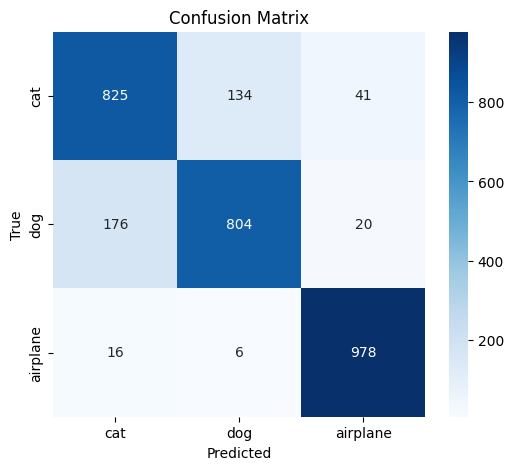


Classification Report:
              precision    recall  f1-score   support

         cat       0.81      0.82      0.82      1000
         dog       0.85      0.80      0.83      1000
    airplane       0.94      0.98      0.96      1000

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [42]:
# 3.2 Performance Reporting
# ============================================================


# ----------------Load the best model----------------
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


# ----------------Final Validation Accuracy----------------
val_acc = (all_preds == all_labels).mean() * 100
print(f"Final Val Acc: {val_acc:.2f}%")


# ----------------Confusion Matrix----------------
cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)


# ----------------Confusion Matrix Plot----------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=SELECTED_CLASSES, yticklabels=SELECTED_CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# ----------------Optional: Classification Report----------------
report = classification_report(all_labels, all_preds, target_names=SELECTED_CLASSES)
print("\nClassification Report:")
print(report)

 # Markdown Analysis:
    # Swapping ReLU activations after the 6th layer with SiLU seems to have helped smooth the gradients, allowing better learning in deeper layers.
    # The training and validation accuracies are quite close, which suggests there’s no major overfitting. However, the slight gap might mean the model is still underfitting a bit on more complex classes.
    # From the confusion matrix, most of the misclassifications happen between visually similar classes — for example, cats and dogs.
    # With more time, I would try:
    # Hyperparameter tuning (learning rate, batch size, optimizer choice).
    # Additional data augmentation (rotation, color jitter).
    # Freeze initial layers for transfer learning and fine-tune deeper layers.
    # Need to try other activation combinations (GELU, LeakyReLU) and deeper ResNet variants (ResNet50).


In [43]:
# 4) Code Quality & Reproducibility
# ============================================================

# 0) ----------------Global Seed----------------
SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

print(f"\nFixed random seed: {SEED}")
print(f"cudnn.deterministic = {torch.backends.cudnn.deterministic}")
print(f"cudnn.benchmark     = {torch.backends.cudnn.benchmark}")



# 1) ----------------Model Helpers----------------

def get_base_model(model_name="resnet18", pretrained=True, num_classes=3):
    """Load ResNet and modify classification head."""
    model_dict = {
        "resnet18": models.resnet18,
        "resnet34": models.resnet34,
        "resnet50": models.resnet50
    }
    if model_name not in model_dict:
        raise ValueError(f"Invalid model_name '{model_name}'")
    model = model_dict[model_name](weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
    # Replace final FC
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    print(f"Using {model_name}, pretrained={pretrained}")
    print(f"Total params: {sum(p.numel() for p in model.parameters()):,}, "
          f"Trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
    return model


def replace_relu_after_n(model, n_keep=6, alt_activation=nn.SiLU()):
    """Replace ReLU activations after n_keep occurrences with alt_activation."""
    relu_indices = []
    counter = [0]  # mutable counter
    def _replace_recursive(module):
        for name, child in module.named_children():
            if isinstance(child, nn.ReLU):
                if counter[0] >= n_keep:
                    setattr(module, name, alt_activation.__class__())
                counter[0] += 1
            else:
                _replace_recursive(child)
    _replace_recursive(model)
    # Sanity check
    relu_count = sum(isinstance(m, nn.ReLU) for m in model.modules())
    alt_count = sum(isinstance(m, alt_activation.__class__) for m in model.modules())
    print(f"ReLU remaining: {relu_count}, {alt_activation.__class__.__name__} inserted: {alt_count}")
    assert relu_count + alt_count == counter[0], "Activation replacement mismatch"
    return model



# 2) ----------------Dataset Helper----------------

def filter_and_relabel_cifar(dataset, selected_classes):
    """Filter CIFAR-10 to selected classes and relabel to contiguous IDs."""
    all_classes = dataset.classes
    # Error handling
    for c in selected_classes:
        assert c in all_classes, f"Class '{c}' not in CIFAR-10"
    class_id_map = {all_classes.index(c): i for i, c in enumerate(selected_classes)}
    # Filter
    indices = [i for i, (_, label) in enumerate(dataset) if label in class_id_map]
    subset = Subset(dataset, indices)
    # Relabel
    subset.dataset.targets = np.array(subset.dataset.targets)
    for i in subset.indices:
        subset.dataset.targets[i] = class_id_map[subset.dataset.targets[i]]
    print(f"Selected classes: {selected_classes}")
    print(f"Original → New IDs: {class_id_map}")
    return subset, class_id_map



# 3) ----------------Training & Evaluation Helpers----------------

def compute_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item() / labels.size(0)


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, running_acc = 0.0, 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += compute_accuracy(outputs, labels)
    return running_loss / len(loader), running_acc / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    running_loss, running_acc = 0.0, 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_acc += compute_accuracy(outputs, labels)
    return running_loss / len(loader), running_acc / len(loader)



# 4) ----------------Reproducibility Summary----------------
set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # Used for training
print('Device used --> ', device)

# Note: sources of nondeterminism
non_deterministic_sources = [
    "Some low-level CUDA operations may still be nondeterministic.",
    "DataLoader multi-threading order if num_workers > 0 can vary slightly."
]


# ----------------Final results----------------
elapsed_time = time.time() - start_time
print("\nReproducibility Summary:")
print(f"Seed used: {SEED}")
print("Non-deterministic sources (if any):")
for note in non_deterministic_sources:
    print(f" - {note}")
print(f"\nTotal runtime for all cells: {int(elapsed_time//60)} min {int(elapsed_time%60)} sec")



Fixed random seed: 42
cudnn.deterministic = True
cudnn.benchmark     = False
Fixed random seed: 42
Device used -->  cpu

Reproducibility Summary:
Seed used: 42
Non-deterministic sources (if any):
 - Some low-level CUDA operations may still be nondeterministic.
 - DataLoader multi-threading order if num_workers > 0 can vary slightly.

Total runtime for all cells: 11 min 58 sec
